# STDSR-2023-Assignment 2

*Violetta Sim, B19-DS-01*

## Task 2: Travelling Salesman Problem with Simulated Annealing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm


### Cities

30 most populous cities of Russia:

In [2]:
city_df = pd.read_csv("city.csv")
city30_df = city_df.nlargest(30, 'population')[["address", "geo_lat", "geo_lon"]]
city30_df.reset_index(inplace=True, drop=True)
city30_df.head()

,address,geo_lat,geo_lon
0,г Москва,55.754047,37.620405
1,г Санкт-Петербург,59.939131,30.315900
2,г Новосибирск,55.028191,82.921149
3,г Екатеринбург,56.838522,60.605491
4,г Нижний Новгород,56.324063,44.005391


How to project longitude and latitude to Cartesian plane, in a way suitable for the geographic position of Russia, so that distances are least distorted:

In [3]:
from pyproj import Transformer
import math

# usual rotation around some origin point
def rotate(origin, point, angle):
    ox, oy = origin
    px, py = point

    qx = ox + math.cos(angle) * (px - ox) - math.sin(angle) * (py - oy)
    qy = oy + math.sin(angle) * (px - ox) + math.cos(angle) * (py - oy)
    return qx, qy

def geographic2cartesian(x, y):
    # Russia - onshore: https://epsg.io/3296-area
    # WGS84 - World Geodetic System 1984: https://epsg.io/4326

    project = Transformer.from_crs("epsg:4326", "epsg:3296").transform
    _x, _y = project(x, y)

    # to make map look nicer
    origin = 2e6, -2.2e7
    _x, _y = rotate(origin, (_x, _y), -2.6*math.pi/8) # to make map look nicer
    return -_x, -_y


Add cartesian coordinates to the dataframe containing cities:

In [4]:
city30_df["x"] = city30_df.apply(lambda row : geographic2cartesian(row['geo_lat'], row['geo_lon'])[0], axis = 1)
city30_df["y"] = city30_df.apply(lambda row : geographic2cartesian(row['geo_lat'], row['geo_lon'])[1], axis = 1)

Check that distances between cities are indeed preserved:

In [5]:
city1 = np.array([city30_df.iloc[1].x, city30_df.iloc[1].y]) # Saint-Petersburg
city2 = np.array([city30_df.iloc[0].x, city30_df.iloc[0].y]) # Moscow

np.linalg.norm(city2-city1)
# true distance is ~634k km

637328.2730565957

### Simulated Annealing Algorithm

In [6]:
N = 30 # number of cities -- the length of a path

# path is list of ids of cities
def cost(path):
    _path = path.copy()
    _path.append(path[0])
    def distance(fi, se):
        city1 = np.array([city30_df.iloc[fi].x, city30_df.iloc[fi].y])
        city2 = np.array([city30_df.iloc[se].x, city30_df.iloc[se].y])
        
        return np.linalg.norm(city2-city1)
    
    return sum([distance(fi, se) for (fi, se) in zip(_path[:-1], _path[1:])])

def neighbour(sample):
    _sample = sample.copy()
    i, j = np.random.randint(0, N, size=2)
    _sample[i], _sample[j] = _sample[j], _sample[i]
    return _sample

In [7]:
from random import shuffle

# alpha - annealing rate
def tsp_simulated_annealing(alpha, iterations=600):
    # initial sample
    sample = list(range(N))
    shuffle(sample)

    # time stamp
    time = 0

    # initial temperature
    T = cost(sample) 
    M = 1 # temperature is decreased every M iterations
    alpha = 0.99 # annealing rate

    samples = [sample]
    temperatures = [T]
    distances = [T]
    a_ratios = [1.0]

    while time < iterations:
        new_sample = neighbour(sample)
        acceptance_ratio = np.exp((-cost(new_sample) + cost(sample))/T)
        u = np.random.random()
        if (u < acceptance_ratio):
            sample = new_sample
        samples.append(sample)
        
        time += 1
        if (time % M == 0):
            T *= alpha
        
        a_ratios.append(min(acceptance_ratio, 1))
        temperatures.append(T)
        distances.append(cost(sample))
    return samples, a_ratios, temperatures, distances


### Visualization of the results

Convert points on borders of Russia from longitude, latitude to cartesian coordinates:

In [8]:
borders = pd.read_json("russia.json")
borders = borders.geojson.iloc[0]["coordinates"]

import itertools
borders = list(itertools.chain(*borders))
borders = list(itertools.chain(*borders))

borders_xy = []
for (i, coords) in tqdm(enumerate(borders)):
    # if ((i % 150) != 0):
    #     continue
    lon, lat = coords[0], coords[1]
    if (not (-168 < lon < 19) and (42 < lat < 81)):
        x, y = geographic2cartesian(lat, lon)
        borders_xy.append([x, y])

borders_xy = np.array(borders_xy)


104804it [21:55, 79.66it/s] 


In [18]:
# Helper functions

def add_borders(ax):
    ax.scatter(borders_xy[:,0], borders_xy[:,1], s=1, c='k')

    
def plot_sample(ax, sample, label, c="g"):
    _sample = sample.copy()
    _sample.append(_sample[0])
    xs, ys = [], []
    for (fi, se) in zip(_sample[:-1], _sample[1:]):
        xs += [city30_df.iloc[fi].x, city30_df.iloc[se].x]
        ys += [city30_df.iloc[fi].y, city30_df.iloc[se].y]
        
    return ax.plot(xs, ys, 'o-', c=c, label=label, linewidth=0.8)
    

def annotate_cities(ax):
    for i in range(N):
        city = city30_df.iloc[i]
        name = city.address[city.address.rfind("г ") +2:]
        ax.text(city.x,city.y,name, fontsize=8)


Generate a gif that represents the progress of the simulated annealing algorithm:

In [34]:
import matplotlib.animation as animation

def animate_tsp(alpha, no_frames=600):
    samples, a_ratios, temperatures, distances = tsp_simulated_annealing(alpha, no_frames)

    fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(10, 8), gridspec_kw=dict(height_ratios=[1, 2]))
    gs = axs[1, 0].get_gridspec()

    for ax in axs[1, :]:
        ax.remove()
    axbig = fig.add_subplot(gs[1, :])
    fig.tight_layout()

    
    annotate_cities(axbig)
    add_borders(axbig)
    path, = axbig.plot([], [], 'o-', c="orange")

    temperature_line, = axs[0,0].plot([], [], c="saddlebrown")
    distance_line, = axs[0,1].plot([], [], c="brown")
    ratios_line, = axs[0,2].plot([], [], ".", markersize=0.85, c="darkgoldenrod")

    axs[0,0].plot(list(range(no_frames)), temperatures[:no_frames], "w", lw=0.3)
    axs[0,1].plot(list(range(no_frames)), distances[:no_frames], "w", lw=0.3)
    axs[0,2].plot(list(range(no_frames)), a_ratios[:no_frames], "w", lw=0.3)

    axs[0, 0].set_title("temperature")
    axs[0, 1].set_title("overall distance")
    axs[0, 2].set_title("acceptance ratio")


    def animate(i):
        _sample = samples[i].copy()
        _sample.append(_sample[0])
        xs, ys = [], []
        for (fi, se) in zip(_sample[:-1], _sample[1:]):
            xs += [city30_df.iloc[fi].x, city30_df.iloc[se].x]
            ys += [city30_df.iloc[fi].y, city30_df.iloc[se].y]
        path.set_data(xs, ys)

        temperature_line.set_data(list(range(i)), temperatures[:i])

        distance_line.set_data(list(range(i)), distances[:i])

        ratios_line.set_data(list(range(i)), a_ratios[:i])

        return path, temperature_line, distance_line


    ani = animation.FuncAnimation(
        fig, animate, no_frames, interval=50, repeat=False)

    ani.save(f"tsp_sa_{alpha}.gif")

/var/folders/y1/jwg9_33n5mz92pdxs2gylb6w0000gn/T/ipykernel_8520/2986314008.py:24: RuntimeWarning: overflow encountered in exp
  acceptance_ratio = np.exp((-cost(new_sample) + cost(sample))/T)
MovieWriter ffmpeg unavailable; using Pillow instead.


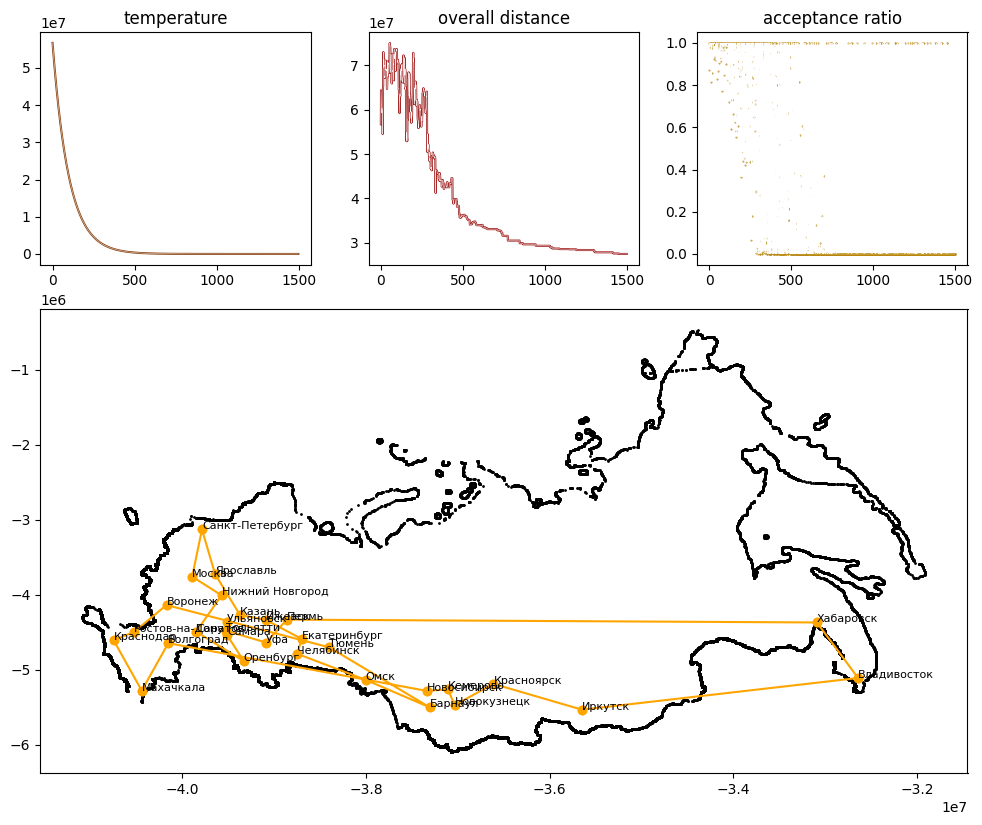

In [35]:
animate_tsp(alpha=0.98, no_frames=1500)

Compare different annealing rates:

/var/folders/y1/jwg9_33n5mz92pdxs2gylb6w0000gn/T/ipykernel_8520/2986314008.py:24: RuntimeWarning: overflow encountered in exp
  acceptance_ratio = np.exp((-cost(new_sample) + cost(sample))/T)


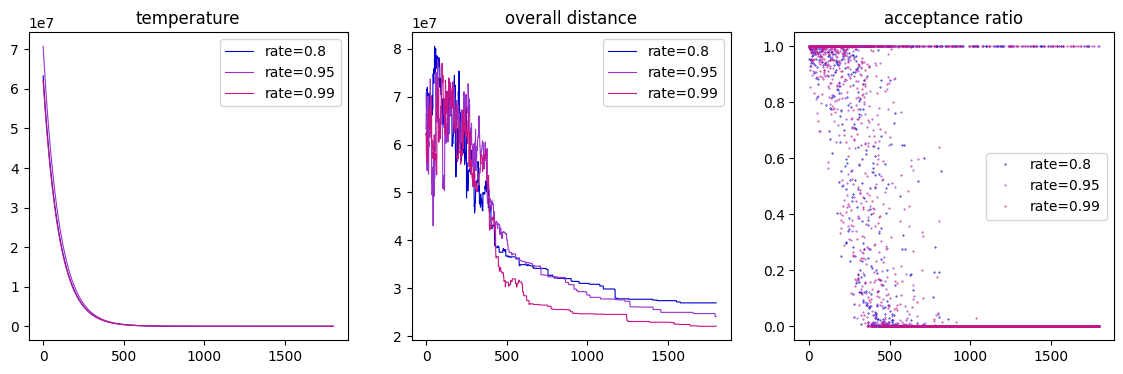

In [52]:
fig, axs = plt.subplots(ncols=3, figsize=(14, 4))

no_frames = 1800
colors = ["mediumblue", "darkorchid", "mediumvioletred"]
alphas = [0.8, 0.95, 0.99]

samples2plot = []

for (alpha, color) in zip(alphas, colors):
    samples, a_ratios, temperatures, distances = tsp_simulated_annealing(alpha, no_frames)


    axs[0].plot(list(range(no_frames)), temperatures[:no_frames], lw=0.8, c=color, label=f"rate={alpha}")
    axs[1].plot(list(range(no_frames)), distances[:no_frames], lw=0.8, c=color,  label=f"rate={alpha}")
    axs[2].plot(list(range(no_frames)), a_ratios[:no_frames], ".", markersize=0.8, c=color, label=f"rate={alpha}")
    samples2plot.append(samples[-1])

axs[0].legend()
axs[0].set_title("temperature")

axs[1].legend()
axs[1].set_title("overall distance")

axs[2].legend()
axs[2].set_title("acceptance ratio")

plt.show()


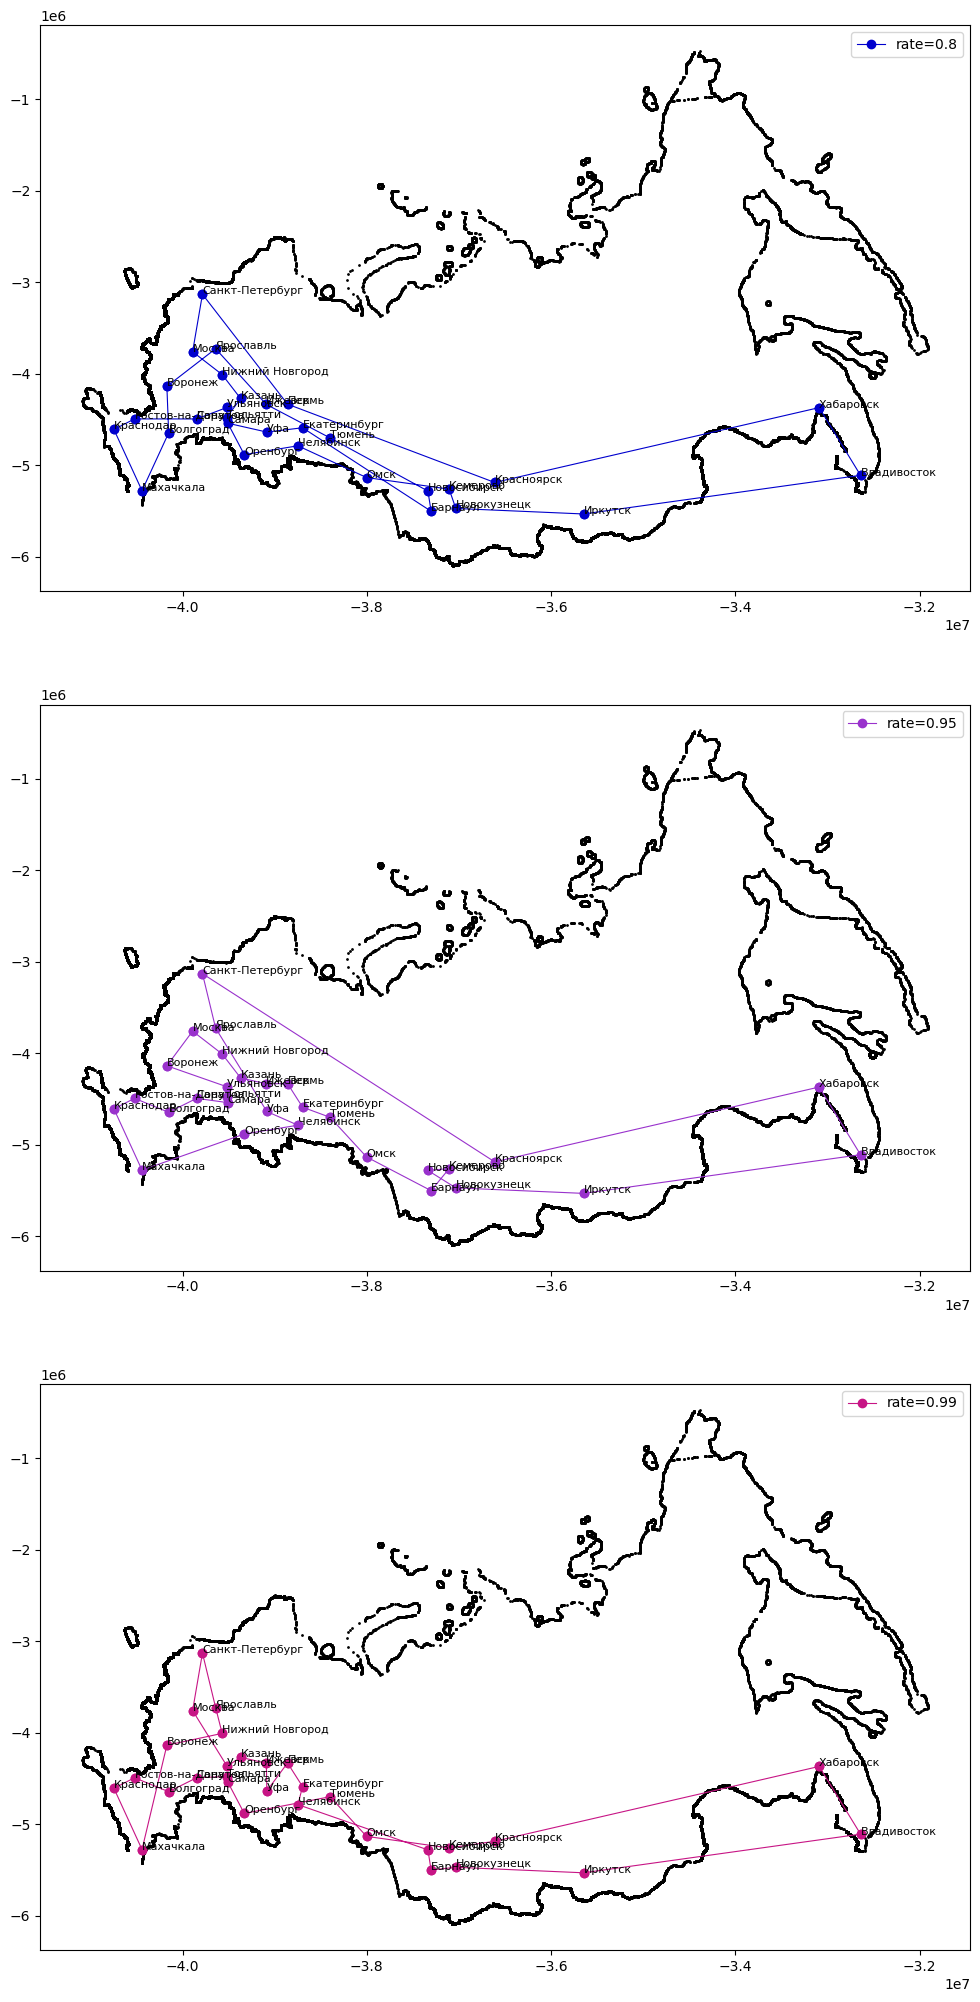

In [53]:
fig, axs = plt.subplots(nrows=3, figsize=(12, 25))

for i, sample in enumerate(samples2plot):
    plot_sample(axs[i], sample, c=colors[i], label=f"rate={alphas[i]}")
    annotate_cities(axs[i])
    add_borders(axs[i])
    axs[i].legend()

plt.show()